<a href="https://colab.research.google.com/github/Shiroi11/Colab-Assignments/blob/main/Colab_6th_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 06

- Set TensorFlow's random seed to 42
- Read data from CSV files and split it into inputs and targets (no need to do train_test_split as the data is already split).
- Tokenize and pad the text, use a vocabulary size of 10,000 and maximum sequence length of 64.
- Do the appropriate operations on the targets to prepare them for training.
- Define the sequential model, make sure to use LSTM and Embedding layers.
- Use Adam optimiser and the appropriate loss function and metrics to compile the model.
- Use ModelCheckpoint callback to save the model at the epoch with the best validation accuracy, the model file should have your name (e.g. for Sabri Monaf, the model's file name would be "sabri_m.h5). Make sure to download the model file as it will be a part of your assignment submission. (the documentation for ModelCheckpoint can be found here: https://www.tensorflow.org/.../callbacks/ModelCheckpoint).
- The training and validation accuracy should be at least 90% and 85% respectively.
- Create a cell in the end that takes in an input string (inputted using Colab Forms (see details here: https://colab.research.google.com/notebooks/forms.ipynb) and uses the trained model to predict (make sure to convert the vector output to the appropriate emoji and print only the emoji at the end of the cell).

# Libraries Importing and Random State Seeding

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
tf.random.set_seed(42)

# Defining the Network's Fixed Parameters

In [3]:
# Vocabulary sample size:
vocab_size = 10000

# Max number of text length:
max_sequence = 64

# Embedding dimensions :
embeddings_dims = 100

# Data Importing and Preprocessing

In [4]:
# Importing Training and Testing Sets:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [5]:
# Splitting Train and Test Data into Features and Targets:
x_train = train.text
y_train = train.emoji

x_test = test.text
y_test = test.emoji

# Displaying the shape of the 4 numpy arrays:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16000,), (16000,), (2000,), (2000,))

In [6]:
# Tokenize X text with defined maximum vocabulary:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words = vocab_size, 
)

# Fitting the Tokenizer on X_train:
tokenizer.fit_on_texts(x_train)

In [7]:
# Transform X_train and X_testusing the defined Tokenizer:
x_train_token = tokenizer.texts_to_sequences(x_train)
x_test_token = tokenizer.texts_to_sequences(x_test)

In [8]:
# Padding X_train and X_test using 0's after the text:
x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(
    x_train_token, maxlen = max_sequence, padding = 'post')

x_test_padded = tf.keras.preprocessing.sequence.pad_sequences(
    x_test_token, maxlen = max_sequence, padding = 'post')

In [9]:
# Replace Target emojis with numbers for calculation purposes, and one_hot encode the outcome:
y_train.replace({'😢':0, '😡':1, '😍':2, '😲':3, '😨':4, '😄':5}, inplace=True)
y_test.replace({'😢':0, '😡':1, '😍':2, '😲':3, '😨':4, '😄':5}, inplace=True)

y_train_1hot = tf.one_hot(y_train, depth=len(set(y_train)))
y_test_1hot = tf.one_hot(y_test, depth=len(set(y_test)))

y_train_1hot = tf.reshape(y_train_1hot, [-1, 6])
y_test_1hot = tf.reshape(y_test_1hot, [-1, 6])

In [10]:
# Create Dataset pipeline for shuffling, patching and prefetching:
def dataset_creator(x, y):
  data = tf.data.Dataset.from_tensor_slices((x, y))
  data = data.shuffle(50000)
  data = data.batch(64)
  data = data.prefetch(tf.data.experimental.AUTOTUNE)
  return data

In [11]:
# Create train and test datasets using data_creator pipeline:
train_dataset = dataset_creator(x_train_padded, y_train_1hot)
test_dataset = dataset_creator(x_test_padded, y_test_1hot)

# Long Short-Term Memory Neural Network

In [12]:
# Constructing the Model:
lstm_model = tf.keras.Sequential([
                                  tf.keras.Input([max_sequence]),
                                  tf.keras.layers.Embedding(vocab_size+1, 100, mask_zero=True),
                                  tf.keras.layers.LSTM(128),
                                  tf.keras.layers.Dense(units=6, activation='softmax')
])

In [13]:
# Displaying the Model's summary:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 100)           1000100   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 1,118,122
Trainable params: 1,118,122
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Compiling the Model:
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [15]:
# Defining the Model's callback:
checkpoint_filepath = '/content'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [16]:
# Fitting the Model
lstm_model.fit(train_dataset, epochs=10, verbose=0,
               validation_data=test_dataset, 
               callbacks=[model_checkpoint_callback])

In [17]:
# Extracting the Historical Data of the Model:
lstm_model_history = pd.DataFrame(lstm_model.history.history)
lstm_model_history.tail()

,loss,accuracy,val_loss,val_accuracy
5,0.055115,0.981438,0.248738,0.9165
6,0.041345,0.984875,0.284422,0.9075
7,0.036615,0.987813,0.307115,0.9130
8,0.031503,0.989563,0.306195,0.9170
9,0.027419,0.991500,0.290089,0.9205


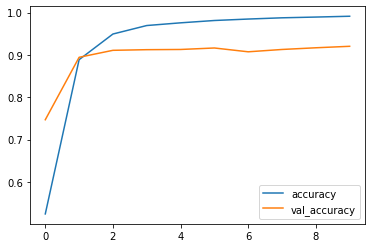

In [18]:
# Plotting Accuracy and Validation Accuracy:
lstm_model_history[['accuracy', 'val_accuracy']].plot.line();

# Saving, Loading and Testing the Model

In [19]:
# Saving the Model:
lstm_model.save('lstm_model.h5')

In [20]:
# Loading the Model:
lstm_model = tf.keras.models.load_model('lstm_model.h5')

In [21]:
# Defining a function that transforms the numerical outputs (probabolities) into emojis
def predict(text):
  tokenized_texts = tokenizer.texts_to_sequences([text])
  input = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_texts, maxlen=max_sequence, padding='post')
  output = lstm_model.predict(input)[0]
  emoji = ['😢', '😡', '😍', '😲', '😨', '😄']
  for index, value in enumerate(output):
    if value == max(output):
      print(text, emoji[index])
      break

In [23]:
# Interactive predictions testing cell:
#@title Emoji Text Prediction

text = 'you look confused ' #@param {type:"string"}

predict(text)

you look confused  😨
